In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import os
from matplotlib.patches import Patch

In [2]:
# load data
directory_path = "PSA_data"

file_pattern = "*1007.csv"

# Combine the directory path with the file pattern
files = glob.glob(os.path.join(directory_path, file_pattern))

# Read and concatenate the CSV files
dataframes = []

for file in files:
    df = pd.read_csv(file)
    dataframes.append(df)
    
df_all = pd.concat(dataframes, ignore_index=True)

# GN vs GNE
## Parameter Sensitivity Analysis

In [12]:
savefig=True
date="241009"
font_size=30
font_size_legend=15
shift = 0.2 # -0.2, 0.2
box_width = 0.3
networks=["GN", "GNE"]

In [13]:
# prepare the dataframe
velocity_df = df_all[["network", "rel change", "velocity", "parameter", "condition 1", "condition 2"]]

# filter for parameters only relevant to the GN and GNE network
mask0 = velocity_df["parameter"].isin(["alphaGN", "alphaEO", "KaaNG", "KmiNG", "KmiEN", "KNEG", "KEG"])
mask1 = velocity_df["network"].isin(networks)

df_GN_GNE = velocity_df[mask0&mask1]

### Plot the figure

In [14]:
# Custom color palette
custom_palette = {'GN': 'red',
                  'GNE': 'green',
                  'GNEO1': 'blue',
                  'GNEO2':'orange'
                 }

# Costom legend (stripe, grey shade)
# all four networks.
legend_elements = [Patch(facecolor="red", edgecolor="red", label="GN-F"),
                   Patch(facecolor="green", edgecolor="green", label="GNE-F"),
                   Patch(facecolor="blue", edgecolor="blue", label="GNEO 1"),
                   Patch(facecolor="orange", edgecolor="orange", label="GNEO 2"),
                   Patch(facecolor="gray", edgecolor="gray", label=r"non bi-stable"),
                   Patch(facecolor="white", edgecolor="gray", hatch="//",label=r"rel. change (SFP) > 20 %")
                  ]

# if only GN and GNE
legend_elements = [Patch(facecolor="red", edgecolor="red", label="GN-F"),
                   Patch(facecolor="green", edgecolor="green", label="GNE-F"),
                   Patch(facecolor="gray", edgecolor="gray", label=r"non bi-stable"),
                   Patch(facecolor="white", edgecolor="gray", hatch="//",label=r"rel. change (SFP) > 20 %")
                  ]


# Costum figure titles
figure_titles = [r"$\alpha_G$, $\alpha_N$",
                 r"$\alpha_E$",
                 "$K_{GG}$, $K_{NN}$",
                 "$K_{GN}$, $K_{NG}$",
                 "$K_{EN}$, $K_{NE}$",
                 "$K_{NEG}$",
                 "$K_{EG}$"
                 ]

filename_key = ["alphaGN", "alphaEO", "KaaNG","KmiNG", "KmiEN", "KNEG", "KEG"]

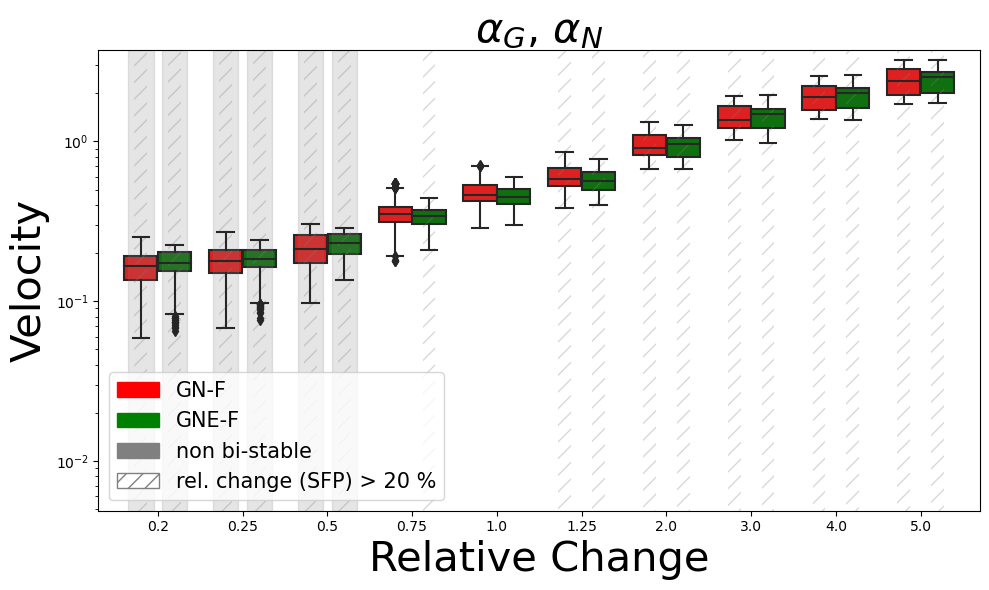

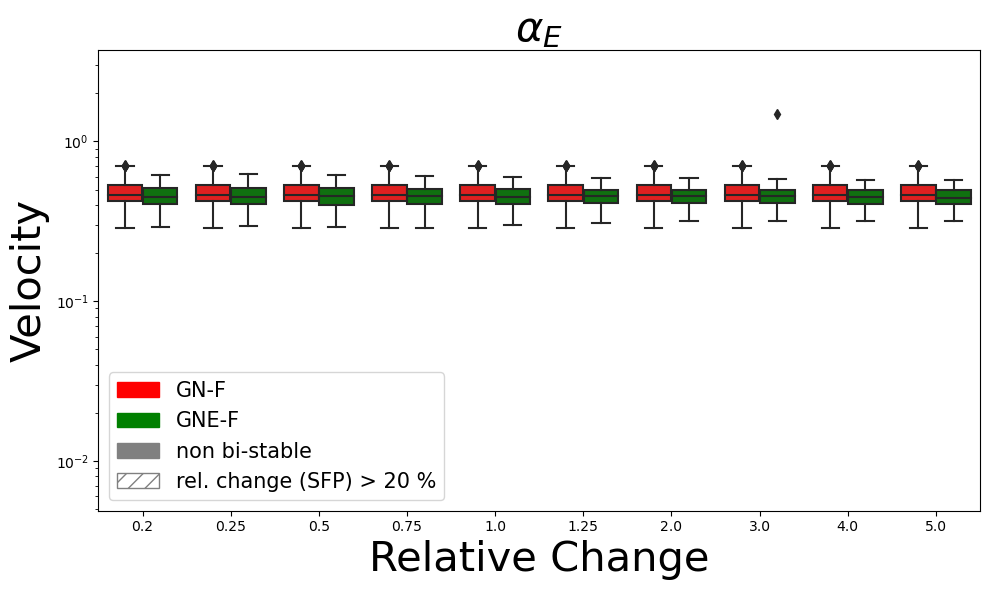

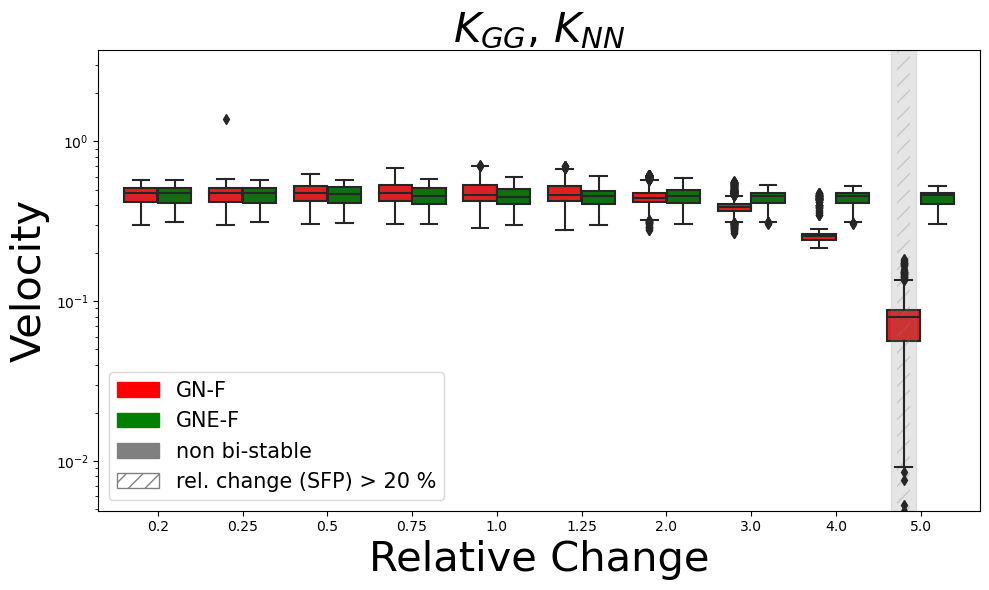

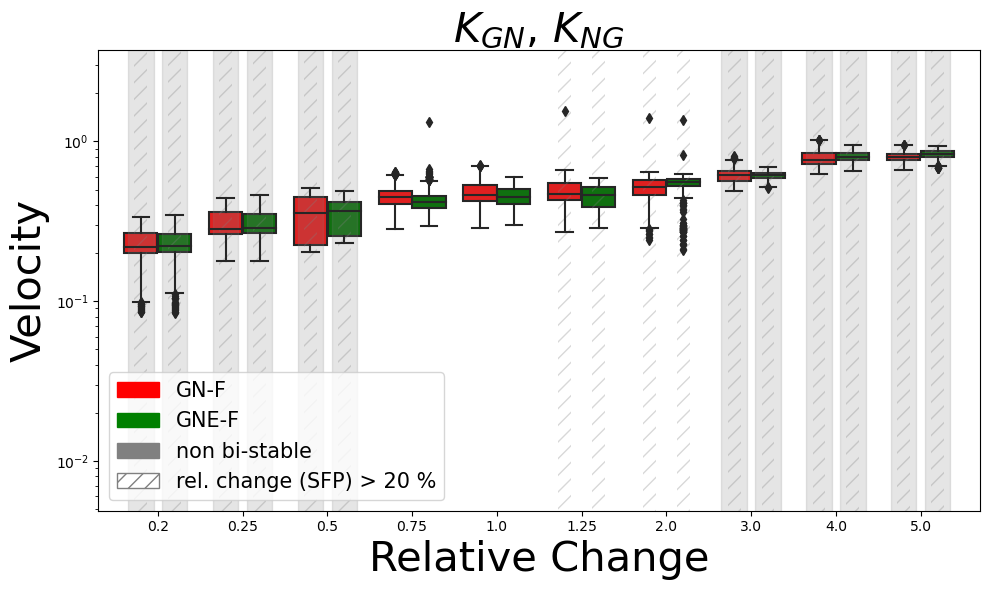

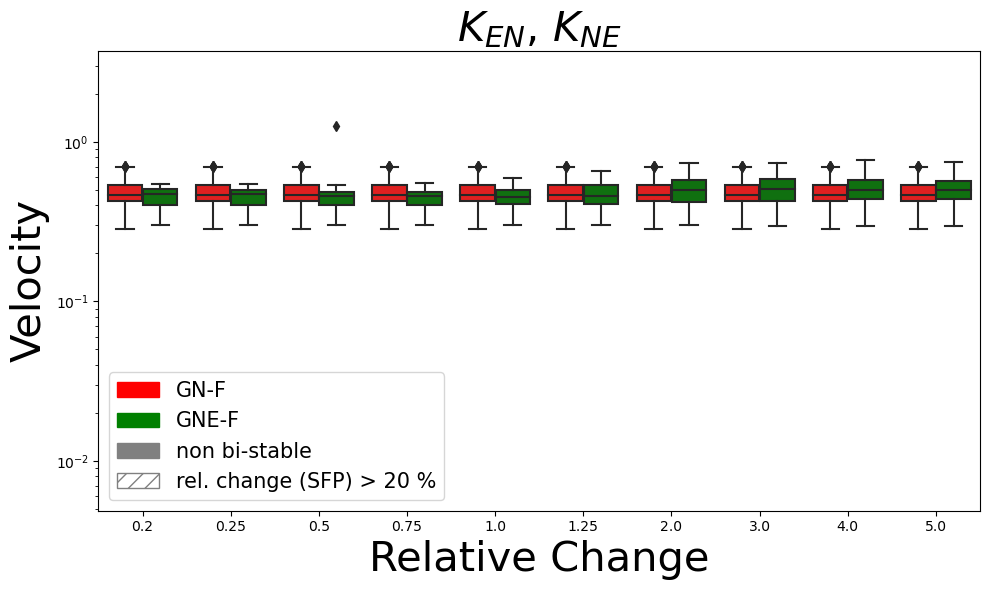

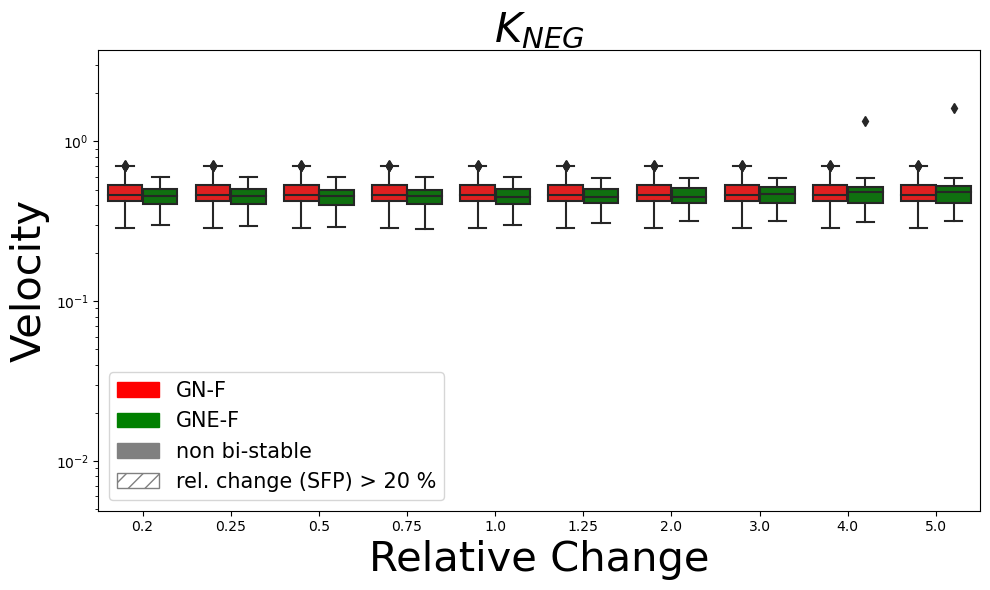

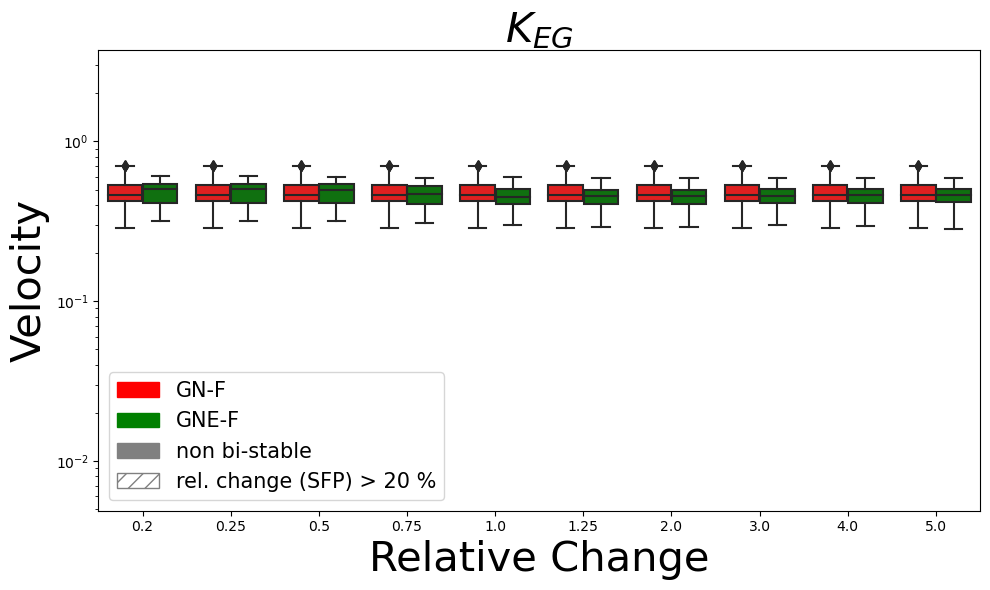

In [16]:
for parameter, title in zip(filename_key,figure_titles):
    
    
    # 0. create new figure
    fig, ax = plt.subplots(figsize=(10,6))
    
    # 1. create grouped boxplot
    
    # 1.1 filter for parameter
    mask = df_GN_GNE["parameter"]==parameter
    
    # 1.2 ensure the categorical order for 'network' (hue) is explicitly set + sort_values("network")
    df_GN_GNE.loc[:,'network'] = pd.Categorical(df_GN_GNE['network'], categories=networks, ordered=True)
    df_GN_GNE_param=df_GN_GNE[mask].sort_values("network")
    
    sns.boxplot(x="rel change",
                y="velocity",
                hue="network",
                data=df_GN_GNE_param,
                palette=custom_palette,
                ax=ax
               )
    
    

    # 2. indicate non bi-stability and disagreement with reference sfp
    ymax = np.max(df_GN_GNE["velocity"]) + 0.5
    ymin = np.min(df_GN_GNE["velocity"]) - 0.5

    dx_arr = np.linspace(-shift, shift, len(networks))

    for network, dx in zip(networks, dx_arr):
        
        df_network = df_GN_GNE_param[df_GN_GNE_param["network"]==network]
        
        
        # Indicate non-bistability
        # x_pos = rel change values at which condition 1 is not True.
        x_pos=df_network[df_network["condition 1"] != True]["rel change"].unique()
        for x in x_pos:
            # all_pos = all rel change at which the PSA is performed. due to .index, it has to be a list.
            all_pos = np.sort(df_GN_GNE["rel change"].unique()).tolist()
            box_position = all_pos.index(x) + dx
            
            # Shade the area behind the boxplot
            ax.fill_betweenx([ymin ,ymax],
                         box_position - box_width/2,
                         box_position + box_width/2,
                         color="gray", alpha=0.2)
            
        # indicate disagreement with reference sfp
        x_pos = df_network[df_network["condition 2"] != True]["rel change"].unique().tolist()
        
        for x in x_pos:
            all_pos = np.sort(df_GN_GNE["rel change"].unique()).tolist()
            box_position = all_pos.index(x) + dx
            
            # Striped Shade the area behind the boxplot
            ax.bar(box_position,
                   ymax - ymin,
                   width=box_width/2, 
                   bottom=ymin,
                   color='none',
                   edgecolor='gray',
                   hatch='//', linewidth=0, alpha=0.3)
    
    # 4. title, axis labels, legends
    ax.set_title(f"{title}", fontsize=font_size)
    ax.set_xlabel("Relative Change", fontsize=font_size)
    ax.set_ylabel("Velocity", fontsize=font_size)
    
    ax.legend(handles=legend_elements, loc="lower left", fontsize=font_size_legend)
    
    # 5. adjust y-axis (ymin, ymax, logscale)
    ymax = np.max(velocity_df["velocity"]) + 0.5
    ymin = np.min(velocity_df["velocity"])
    
    if ymin < 0: # avoid trouble with logscale
        ymin=0
        
    ax.set_ylim(ymin, ymax)
    ax.set_yscale("log")
    
    # 6. adjust figure
    plt.tight_layout()
    
    # 7. save figures
    if savefig:
        plt.savefig(f"velocity_boxplots_{networks}_{parameter}_{date}.pdf", dpi=600)